In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt

### After Boostrap finishes, inspect the {boostrap-based, model-based}significance integrated adata, diagnose the significance score:
- Call GSEA on the [-log10({boostrap-based, model-based}-q-val) *  loading value] [loading value]
- Think about different ways that we can do significance score diagnosis

In [2]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
post_bootstrap_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_bootstrap_oct7.h5ad"
post_bootstrap_adata = sc.read_h5ad(post_bootstrap_h5ad)

# Extract FA + bootstrap fields
L = np.asarray(post_bootstrap_adata.varm["fs_loadings"])               # (p, k)
Z = np.asarray(post_bootstrap_adata.obsm["fs_scores"])                 # (n, k)
Z_loading = np.asarray(post_bootstrap_adata.varm["fs_loading_z"])      # (p, k)
Q = np.asarray(post_bootstrap_adata.varm["fs_loading_q"])              # (p, k) FDR q-values
stab = np.asarray(post_bootstrap_adata.varm["fs_loading_stability"])   # (p, k)

p, k = L.shape
print("Shapes L/Z/z/q/stab:", L.shape, Z.shape, Z_loading.shape, Q.shape, stab.shape)

Shapes L/Z/z/q/stab: (15679, 100) (60118, 100) (15679, 100) (15679, 100) (15679, 100)


In [3]:
post_bootstrap_adata.varm['fs_loading_stability'].shape

(15679, 100)

In [4]:
# Cell 2 — Quick bootstrap diagnostics
# 1) per-factor # of significant genes (q < 0.05, 0.1)
sig_005 = (Q < 0.05).sum(axis=0)
sig_010 = (Q < 0.10).sum(axis=0)
print("Median #sig(q<0.05) per factor:", int(np.median(sig_005)))
print("Median #sig(q<0.10) per factor:", int(np.median(sig_010)))
print("Total number of genes per factor:", L.shape[0])

# 2) per-factor stability summary (fraction of genes above threshold)
frac_stab_0p5 = (stab > 0.5).mean(axis=0)
print("Median frac(stability>0.5) per factor:", float(np.median(frac_stab_0p5)))

# 3) simple |L| vs significance coupling on top factors (ids of top factors by #sig)
top_factors = np.argsort(-sig_005)[:5]
print("Top factors by #sig(q<0.05):", top_factors.tolist())

Median #sig(q<0.05) per factor: 2524
Median #sig(q<0.10) per factor: 3269
Total number of genes per factor: 15679
Median frac(stability>0.5) per factor: 0.011129536322469546
Top factors by #sig(q<0.05): [70, 59, 57, 75, 27]


In [5]:
# Cell 3 — Count significance "hits across the board"
# - per-factor counts at multiple thresholds
# - per-gene count of significant factors (how many factors each gene is significant for)

thresholds = [0.01, 0.05, 0.10]
for t in thresholds:
    print(f"q < {t}: median per-factor significant genes = {int(np.median((Q < t).sum(axis=0)))}")

sig_count_per_gene = (Q < 0.05).sum(axis=1)  # across factors
print("Median factors-per-gene with q<0.05:", int(np.median(sig_count_per_gene)))

q < 0.01: median per-factor significant genes = 1554
q < 0.05: median per-factor significant genes = 2524
q < 0.1: median per-factor significant genes = 3269
Median factors-per-gene with q<0.05: 24


In [3]:
# Cell 4 — Build per-factor ranked lists: score = -log10(q-val) * loading
# since q-val is multiple testing corrected, it is more conservative than p-val

Q = np.clip(Q, 1e-300, 1.0) # clip q-val to avoid inf
# Ranking score: signed loading weighted by -log10(p)
score = -np.log10(Q) * L   # (p, k), preserves gene order in adata.var_names

# Build per-factor pandas Series
gene_names = post_bootstrap_adata.var_names.to_numpy()
ranked_per_factor = {
    f"factor_{j}": pd.Series(score[:, j], index=gene_names).sort_values(ascending=False)
    for j in range(k)
}

# Optional: write .rnk files for GSEA preranked
# out_dir = "/home/minhang/mds_project/data/cohort_adata/gsea_preranked_oct7"
# Path(out_dir).mkdir(parents=True, exist_ok=True)
# for j, s in ranked_per_factor.items():
#     s.to_csv(f"{out_dir}/{j}.rnk", sep="\t", header=False)

In [18]:
len(ranked_per_factor["factor_0"])

15679

### Run GSEA with the ranked list as input [L, model-based-sig-val + L, stability-based-sig-val + L]
- Compare multiplying loading value with q-val 
- Just use the loading value

In [18]:
# Build rankers: rank = -log10(q) * loading
import gseapy as gp
from pathlib import Path

Qc = np.clip(Q, 1e-300, 1.0)
rank = -np.log10(Qc) * L
ranked_per_factor = {
    f"factor_{j}": pd.Series(rank[:, j], index=gene_names).sort_values(ascending=False)
    for j in range(k)
}

gene_sets = "/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt"
out_root = "/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_bootstrap_oct7/comb_sig_n_loading/"
Path(out_root).mkdir(parents=True, exist_ok=True)

selected = range(k)  # or a subset like top factors by #sig genes
summary = {} # store the number of significant pathways for each factor
for name, series in ranked_per_factor.items():
    out_dir = Path(out_root) / name
    out_dir.mkdir(parents=True, exist_ok=True)
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=gene_sets,
        processes=4,
        permutation_num=1000,
        outdir=str(out_dir),
        seed=0,
        min_size=10,
        max_size=5000,
        no_plot=True,
        format="png",
    )
    res_df = res.res2d
    summary[name] = int((res_df["FDR q-val"] < 0.05).sum())

pd.Series(summary).sort_values(ascending=False)

/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarn

factor_53    15
factor_30    11
factor_70     8
factor_10     5
factor_84     4
             ..
factor_61     0
factor_62     0
factor_63     0
factor_64     0
factor_0      0
Length: 100, dtype: int64

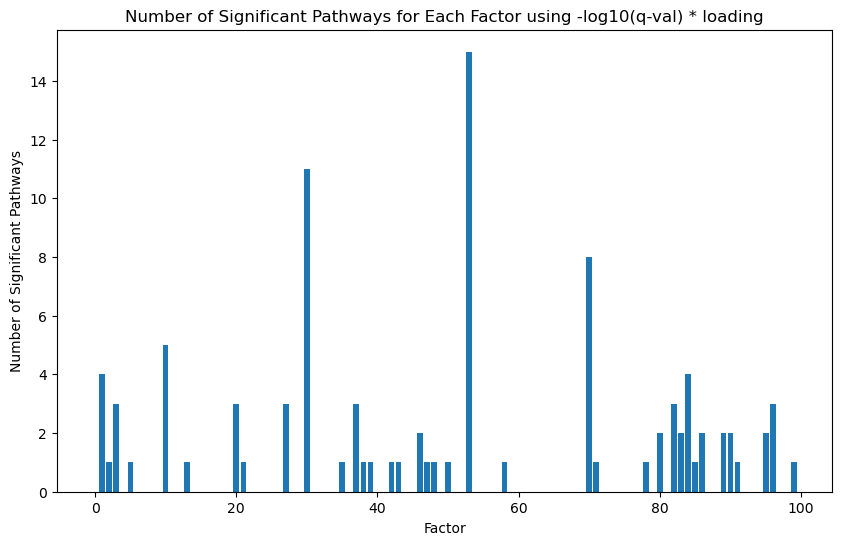

In [19]:
# plot the number of significant pathways for each factor
plt.figure(figsize=(10, 6))
# x-axis just use a number 0, 1, 2, ..., k-1
plt.bar(range(k), list(summary.values()))
plt.xlabel("Factor")
plt.ylabel("Number of Significant Pathways")
plt.title("Number of Significant Pathways for Each Factor using -log10(q-val) * loading")
plt.show()

Loading 

In [14]:
loading_rank = L
loading_ranked_per_factor = {
    f"factor_{j}": pd.Series(loading_rank[:, j], index=gene_names).sort_values(ascending=False)
    for j in range(k)
}

gene_sets = "/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt"
out_root = "/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_bootstrap_oct7/just_loading/"
Path(out_root).mkdir(parents=True, exist_ok=True)

selected = range(k)  # or a subset like top factors by #sig genes
summary = {} # store the number of significant pathways for each factor
for name, series in loading_ranked_per_factor.items():
    out_dir = Path(out_root) / name
    out_dir.mkdir(parents=True, exist_ok=True)
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=gene_sets,
        processes=4,
        permutation_num=1000,
        outdir=str(out_dir),
        seed=0,
        min_size=10,
        max_size=5000,
        no_plot=True,
        format="png",
    )
    res_df = res.res2d
    summary[name] = int((res_df["FDR q-val"] < 0.05).sum())

pd.Series(summary).sort_values(ascending=False)

/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: proc

factor_70    31
factor_6     31
factor_53    29
factor_85    23
factor_37    21
             ..
factor_67     0
factor_92     0
factor_63     0
factor_72     0
factor_31     0
Length: 100, dtype: int64

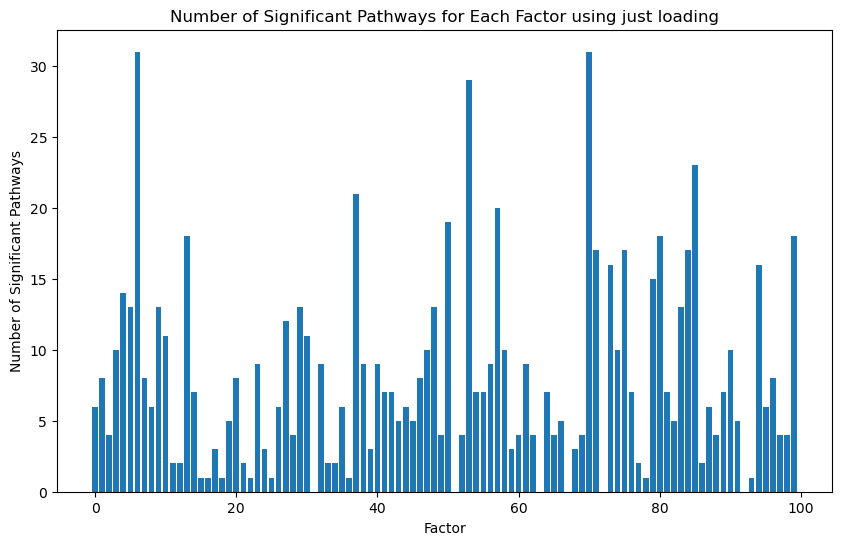

In [16]:
# plot the number of significant pathways for each factor
plt.figure(figsize=(10, 6))
# x-axis just use a number 0, 1, 2, ..., k-1
plt.bar(range(k), list(summary.values()))
plt.xlabel("Factor")
plt.ylabel("Number of Significant Pathways")
plt.title("Number of Significant Pathways for Each Factor using just loading")
plt.show()

### Systematic comparisons of L vs. -log10(q) * L
- Compare distributions: plot per-factor |L| vs -log10(q) and color by stability; look for rightmost points (big |L|) with low -log10(q) and low stability.
- Correlate ranks: Spearman between loading-only rank and q-weighted rank per factor.
- Count overlap at top N: |topN(load) ∩ topN(q-weighted)| / N.
- Track BH load: for each factor, plot empirical CDF of p and overlay BH threshold lines.

In [21]:
import numpy as np
import pandas as pd

L = np.asarray(post_bootstrap_adata.varm["fs_loadings"])
Q = np.asarray(post_bootstrap_adata.varm["fs_loading_q"])
stab = np.asarray(post_bootstrap_adata.varm["fs_loading_stability"])
genes = post_bootstrap_adata.var_names.to_numpy()
p, k = L.shape

Qc = np.clip(Q, 1e-300, 1.0)
rank_q = -np.log10(Qc) * L

summ = []
overlaps = []
for j in range(k):
    s_load = pd.Series(L[:, j], index=genes).sort_values(ascending=False)
    s_q = pd.Series(rank_q[:, j], index=genes).sort_values(ascending=False)
    # Spearman correlation between ranks (top direction)
    spearman = s_load.rank(ascending=False).corr(s_q.rank(ascending=False), method="spearman")
    # Top-N overlap
    N = 200
    top_load = set(s_load.index[:N])
    top_q = set(s_q.index[:N])
    overlap = len(top_load & top_q) / float(N)
    overlaps.append(overlap)
    # Summaries
    summ.append({
        "factor": j,
        "spearman_rank_corr": spearman,
        "topN_overlap": overlap,
        "n_sig_q005": int((Q[:, j] < 0.05).sum()),
        "median_stability": float(np.median(stab[:, j])),
        "median_abs_loading": float(np.median(np.abs(L[:, j]))),
    })
diag_df = pd.DataFrame(summ).sort_values("spearman_rank_corr", ascending=True)


In [22]:
diag_df

,factor,spearman_rank_corr,topN_overlap,n_sig_q005,median_stability,median_abs_loading
96,96,0.975763,0.565,1026,0.00,0.014102
53,53,0.984664,0.680,12013,0.00,0.016764
50,50,0.986794,0.380,1955,0.00,0.010684
69,69,0.988268,0.635,1918,0.00,0.007895
80,80,0.990117,0.495,7737,0.00,0.014790
...,...,...,...,...,...,...
10,10,0.999989,0.905,0,0.00,0.007111
4,4,0.999994,0.935,0,0.01,0.006826
31,31,0.999999,0.990,1,0.01,0.006694
78,78,0.999999,0.975,12,0.00,0.005437


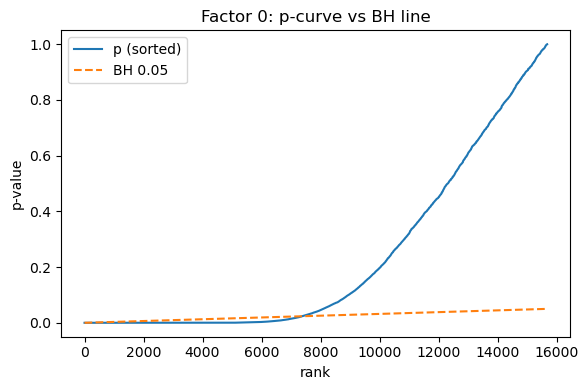

In [24]:
import matplotlib.pyplot as plt

j = 0
pvals = np.asarray(post_bootstrap_adata.varm.get("fs_loading_p", np.minimum(Q, 1.0)))[:, j]
pvals = np.clip(pvals, 1e-300, 1.0)
p_sorted = np.sort(pvals)
m = len(p_sorted)
bh_line = (np.arange(1, m+1) / m) * 0.05

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, m+1), p_sorted, label="p (sorted)")
plt.plot(np.arange(1, m+1), bh_line, ls="--", label="BH 0.05")
plt.xlabel("rank")
plt.ylabel("p-value")
plt.title(f"Factor {j}: p-curve vs BH line")
plt.legend()
plt.tight_layout()
plt.show()

Older stuff

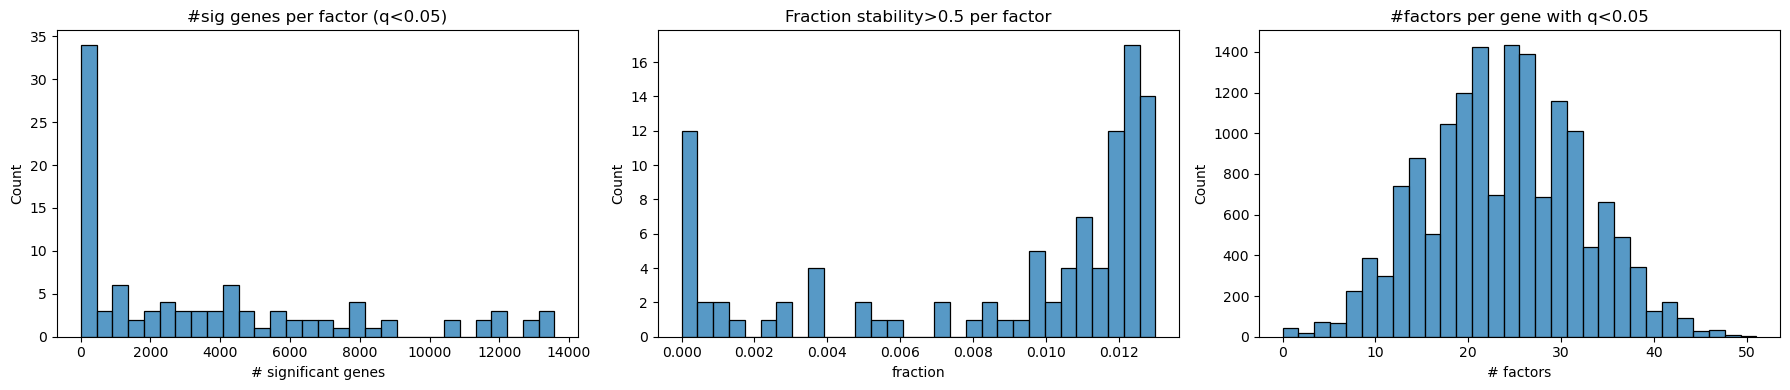

In [5]:
# Cell 5 — Optional: visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(sig_005, bins=30, ax=axes[0])
axes[0].set_title("#sig genes per factor (q<0.05)")
axes[0].set_xlabel("# significant genes")

sns.histplot(frac_stab_0p5, bins=30, ax=axes[1])
axes[1].set_title("Fraction stability>0.5 per factor")
axes[1].set_xlabel("fraction")

sns.histplot(sig_count_per_gene, bins=30, ax=axes[2])
axes[2].set_title("#factors per gene with q<0.05")
axes[2].set_xlabel("# factors")

plt.tight_layout()
plt.show()

### For a factor (0-based), inspect genes with high |loading| but low significance

In [3]:
import numpy as np
import pandas as pd

L = np.asarray(post_bootstrap_adata.varm["fs_loadings"])               # (p, k)
Z_loading = np.asarray(post_bootstrap_adata.varm["fs_loading_z"])      # (p, k)
Q = np.asarray(post_bootstrap_adata.varm["fs_loading_q"])              # (p, k)
stab = np.asarray(post_bootstrap_adata.varm["fs_loading_stability"])   # (p, k)
genes = post_bootstrap_adata.var_names.to_numpy()
p, k = L.shape

# Choose a factor to inspect (0-based)
j = 0

df = pd.DataFrame({
    "gene": genes,
    "loading": L[:, j],
    "abs_loading": np.abs(L[:, j]),
    "z": Z_loading[:, j],
    "q": Q[:, j],
    "stability": stab[:, j],
}).sort_values("abs_loading", ascending=False)

# High effect but not significant (tune thresholds as needed)
hi_abs = df["abs_loading"].quantile(0.95)
candidates = df[(df["abs_loading"] >= hi_abs) & (df["q"] >= 0.10)].head(50)

x = L[:, j]
y = -np.log10(np.clip(Q[:, j], 1e-300, 1.0))
c = stab[:, j]

plt.figure(figsize=(6,4))
sc = plt.scatter(x, y, c=c, s=6, cmap="viridis")
plt.colorbar(sc, label="stability")
plt.axhline(-np.log10(0.05), color="tomato", lw=1, ls="--")
plt.xlabel("loading")
plt.ylabel("-log10(q)")
plt.title(f"Factor {j}: loading vs -log10(q)")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

### Load model-based AnnData and align genes

What we’re doing:
- Load the model-based significance AnnData and align its genes to the bootstrap AnnData so that arrays are strictly comparable (same genes, same order).
- Define three rankers per factor for downstream comparisons:
  - R_load = L
  - R_boot = -log10(q_boot) × L
  - R_model = -log10(q_model) × L

What to look for:
- Confirm `p, k` match and that the rankers have the same shapes.
- All subsequent analyses assume this alignment.


In [3]:
import anndata as ad
import numpy as np
import pandas as pd
from pathlib import Path

# Load model-based AnnData
model_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_modelsig_oct7.h5ad"
ad_model = ad.read_h5ad(model_h5ad)

# Ensure bootstrap AnnData is already loaded earlier as `post_bootstrap_adata`
ad_boot = post_bootstrap_adata

# Align genes: subset/reorder model to bootstrap’s gene order
boot_genes = ad_boot.var_names.to_numpy()
model_genes = ad_model.var_names.to_numpy()
name_to_idx_model = {g: i for i, g in enumerate(model_genes)}
missing_in_model = [g for g in boot_genes if g not in name_to_idx_model]
if missing_in_model:
    raise RuntimeError(f"Model AnnData missing {len(missing_in_model)} genes found in bootstrap AnnData; e.g., {missing_in_model[:5]}")
idx_model = np.asarray([name_to_idx_model[g] for g in boot_genes], dtype=int)
ad_model = ad_model[:, boot_genes].copy()

# Extract fields
L = np.asarray(ad_boot.varm["fs_loadings"])               # (p, k)
Q_boot = np.asarray(ad_boot.varm["fs_loading_q"])         # (p, k)
stab = np.asarray(ad_boot.varm.get("fs_loading_stability", np.full_like(L, np.nan)))

# Model-based significance
Q_model = np.asarray(ad_model.varm["fs_loading_q_model"]) # (p, k)
P_model = np.asarray(ad_model.varm.get("fs_loading_p_model", np.minimum(Q_model, 1.0)))
SE_boot = np.asarray(ad_boot.varm.get("fs_loading_se", np.full_like(L, np.nan)))
SE_model = np.asarray(ad_model.varm.get("fs_loading_se_model", np.full_like(L, np.nan)))

# Construct rankers
Qc_boot = np.clip(Q_boot, 1e-300, 1.0)
Qc_model = np.clip(Q_model, 1e-300, 1.0)
R_load = L
R_boot = -np.log10(Qc_boot) * L
R_model = -np.log10(Qc_model) * L

p, k = L.shape
print("Shapes L/Q_boot/Q_model/R_load/R_boot/R_model:", L.shape, Q_boot.shape, Q_model.shape, R_load.shape, R_boot.shape, R_model.shape)


Shapes L/Q_boot/Q_model/R_load/R_boot/R_model: (15679, 100) (15679, 100) (15679, 100) (15679, 100) (15679, 100) (15679, 100)


### Rank correlations and overlaps among R_load, R_boot, R_model

What we’re doing:
- For each factor, compute rank correlations (Spearman and Kendall tau-b) among the three rankers.
- Compute top-N overlaps for N in {50, 100, 200, 500}.

What to look for:
- High Spearman/Kendall and large overlaps suggest agreement on prioritizing genes.
- Disagreements can highlight factors where significance weighting diverges from raw loadings.


In [4]:
from scipy.stats import spearmanr, kendalltau

Ns = [50, 100, 200, 500]

rank_stats = []
for j in range(k):
    s_load = pd.Series(R_load[:, j], index=boot_genes).rank(ascending=False, method="average")
    s_boot = pd.Series(R_boot[:, j], index=boot_genes).rank(ascending=False, method="average")
    s_model = pd.Series(R_model[:, j], index=boot_genes).rank(ascending=False, method="average")

    # Spearman correlations among pairs
    sp_lb = spearmanr(s_load, s_boot, nan_policy="omit").correlation
    sp_lm = spearmanr(s_load, s_model, nan_policy="omit").correlation
    sp_bm = spearmanr(s_boot, s_model, nan_policy="omit").correlation

    # Kendall tau-b (handles ties)
    kd_lb = kendalltau(s_load, s_boot, nan_policy="omit").correlation
    kd_lm = kendalltau(s_load, s_model, nan_policy="omit").correlation
    kd_bm = kendalltau(s_boot, s_model, nan_policy="omit").correlation

    # Overlaps at Ns
    overlaps = {}
    order_load = s_load.sort_values().index  # lower rank value is better
    order_boot = s_boot.sort_values().index
    order_model = s_model.sort_values().index
    for N in Ns:
        topL = set(order_load[:N])
        topB = set(order_boot[:N])
        topM = set(order_model[:N])
        overlaps[f"overlap_load_boot@{N}"] = len(topL & topB) / float(N)
        overlaps[f"overlap_load_model@{N}"] = len(topL & topM) / float(N)
        overlaps[f"overlap_boot_model@{N}"] = len(topB & topM) / float(N)

    rank_stats.append({
        "factor": j,
        "spearman_lb": sp_lb, "spearman_lm": sp_lm, "spearman_bm": sp_bm,
        "kendall_lb": kd_lb, "kendall_lm": kd_lm, "kendall_bm": kd_bm,
        **overlaps
    })

rank_stats_df = pd.DataFrame(rank_stats)
rank_stats_df.sort_values(["spearman_bm", "spearman_lm", "spearman_lb"], ascending=False)


,factor,spearman_lb,spearman_lm,spearman_bm,kendall_lb,kendall_lm,kendall_bm,overlap_load_boot@50,overlap_load_model@50,overlap_boot_model@50,overlap_load_boot@100,overlap_load_model@100,overlap_boot_model@100,overlap_load_boot@200,overlap_load_model@200,overlap_boot_model@200,overlap_load_boot@500,overlap_load_model@500,overlap_boot_model@500
37,37,0.999345,0.999506,0.999415,0.979497,0.987069,0.980497,0.86,0.82,0.86,0.86,0.85,0.88,0.875,0.865,0.890,0.904,0.918,0.922
2,2,0.999970,0.999357,0.999338,0.999237,0.985638,0.985175,0.60,0.86,0.54,0.65,0.86,0.56,0.675,0.915,0.685,0.964,0.922,0.914
30,30,1.000000,0.999316,0.999316,0.999999,0.985268,0.985267,1.00,0.80,0.80,1.00,0.88,0.88,1.000,0.870,0.870,1.000,0.938,0.938
79,79,0.999254,0.999403,0.999300,0.978664,0.986303,0.978664,0.86,0.86,0.88,0.93,0.94,0.91,0.940,0.940,0.925,0.946,0.948,0.928
48,48,0.999404,0.999575,0.999284,0.981400,0.988271,0.980751,0.80,0.98,0.78,0.89,0.91,0.84,0.905,0.920,0.890,0.934,0.944,0.914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,35,0.991719,0.998979,0.989404,0.929771,0.982495,0.921184,0.70,0.86,0.60,0.71,0.93,0.67,0.770,0.950,0.735,0.770,0.956,0.742
69,69,0.988268,0.999425,0.987909,0.909974,0.986791,0.908649,0.64,0.88,0.58,0.64,0.93,0.61,0.635,0.930,0.625,0.678,0.948,0.684
50,50,0.986794,0.999339,0.986380,0.907504,0.985909,0.905851,0.38,0.86,0.38,0.35,0.88,0.36,0.380,0.890,0.365,0.470,0.920,0.484
53,53,0.984664,0.998789,0.981735,0.906116,0.981960,0.897951,0.58,0.72,0.48,0.65,0.76,0.62,0.680,0.875,0.645,0.786,0.892,0.760


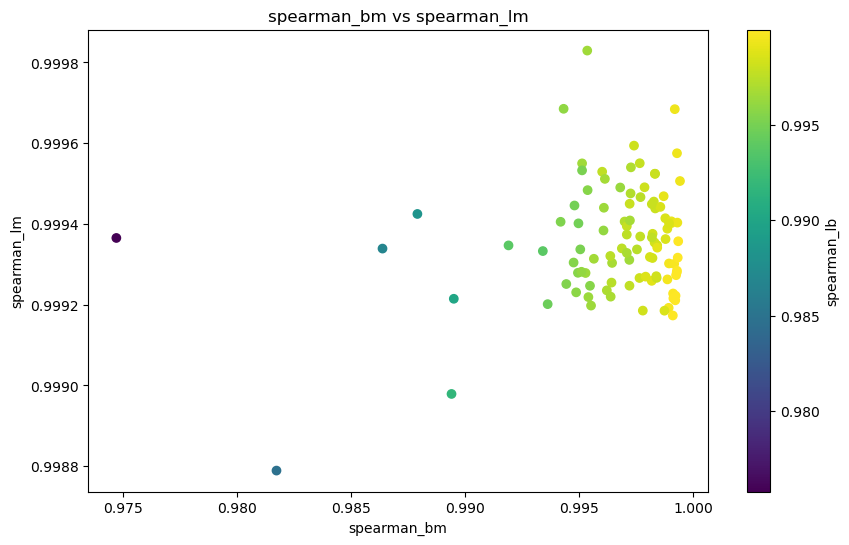

In [5]:
# plot the rank_stats_df
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rank_stats_df["spearman_bm"], rank_stats_df["spearman_lm"], c=rank_stats_df["spearman_lb"], cmap="viridis")
plt.colorbar(label="spearman_lb")
plt.xlabel("spearman_bm")
plt.ylabel("spearman_lm")
plt.title("spearman_bm vs spearman_lm")
plt.show()


In [6]:
rank_stats_df.shape

(100, 19)

### Jaccard overlap curves across N

What we’re doing:
- For each factor and for N from 10 to 2000, compute Jaccard overlap of top-N sets between pairs of rankers.

What to look for:
- Whether agreement holds across cutoffs or diverges at stricter/looser thresholds.


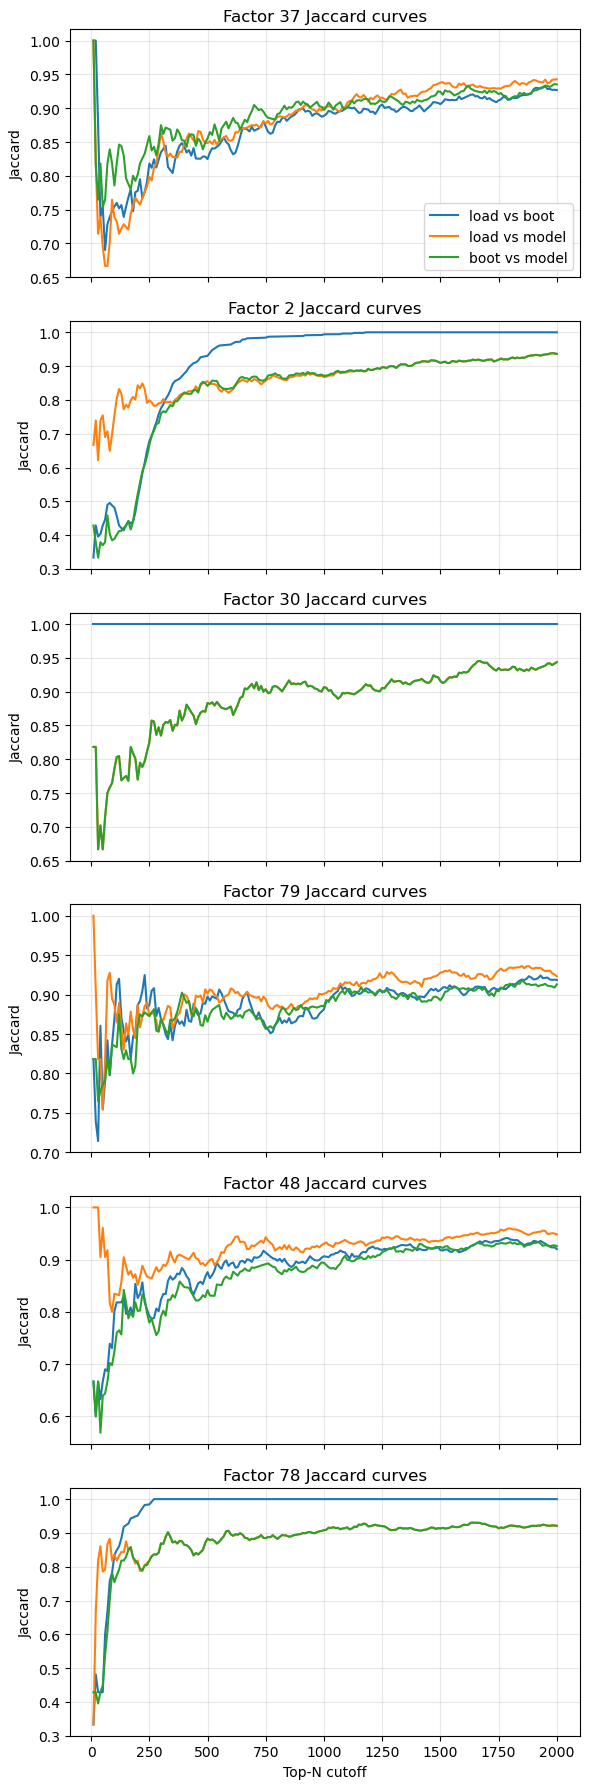

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# compute the unique values of N_grid, which is the range of N from 10 to 2000, with a step of 10
N_grid = np.unique(np.clip(np.arange(10, min(2000, p)+1, 10), 1, p)).astype(int)

# Precompute ranked order indices once per factor
orders = []
for j in range(k):
    s_load = pd.Series(R_load[:, j], index=boot_genes).rank(ascending=False, method="average").sort_values()
    s_boot = pd.Series(R_boot[:, j], index=boot_genes).rank(ascending=False, method="average").sort_values()
    s_model = pd.Series(R_model[:, j], index=boot_genes).rank(ascending=False, method="average").sort_values()
    orders.append((s_load.index.to_numpy(), s_boot.index.to_numpy(), s_model.index.to_numpy()))

# Plot a few representative factors (top 6 by spearman_bm)
plot_factors = rank_stats_df.sort_values("spearman_bm", ascending=False).head(6)["factor"].tolist()

fig, axes = plt.subplots(len(plot_factors), 1, figsize=(6, 3*len(plot_factors)), sharex=True)
if len(plot_factors) == 1:
    axes = [axes]

for ax, j in zip(axes, plot_factors):
    ordL, ordB, ordM = orders[j]
    jacc_lb = []
    jacc_lm = []
    jacc_bm = []
    for N in N_grid:
        setL = set(ordL[:N])
        setB = set(ordB[:N])
        setM = set(ordM[:N])
        def jac(a, b):
            inter = len(a & b)
            union = len(a | b)
            return inter / union if union else 0.0
        jacc_lb.append(jac(setL, setB))
        jacc_lm.append(jac(setL, setM))
        jacc_bm.append(jac(setB, setM))
    ax.plot(N_grid, jacc_lb, label="load vs boot")
    ax.plot(N_grid, jacc_lm, label="load vs model")
    ax.plot(N_grid, jacc_bm, label="boot vs model")
    ax.set_title(f"Factor {j} Jaccard curves")
    ax.set_ylabel("Jaccard")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Top-N cutoff")
axes[0].legend(loc="lower right")
plt.tight_layout()
plt.show()


### Significance: model vs bootstrap scatter and Bland–Altman

What we’re doing:
- For each factor, compare -log10(q_model) vs -log10(q_boot); color by |L| or stability.
- Bland–Altman: difference vs mean of -log10(q)’s.

What to look for:
- Points near y=x indicate agreement; systematic deviations indicate bias.
- In Bland–Altman, mean-centered differences near 0 are desirable; structure vs |L| or stability can reveal where methods diverge.


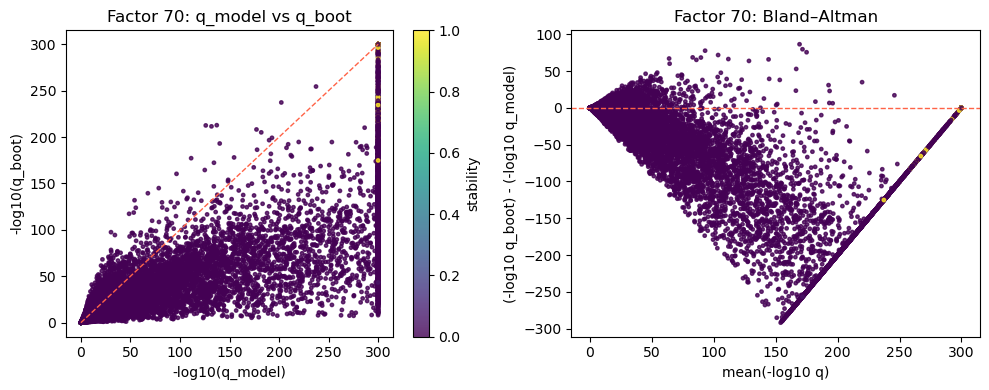

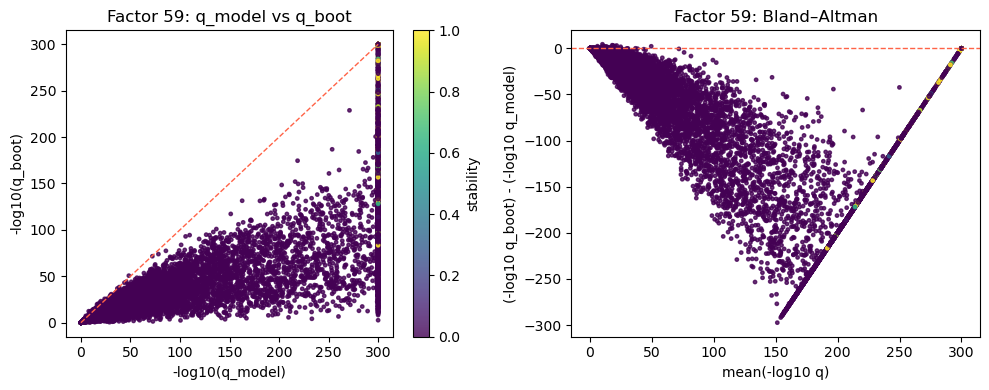

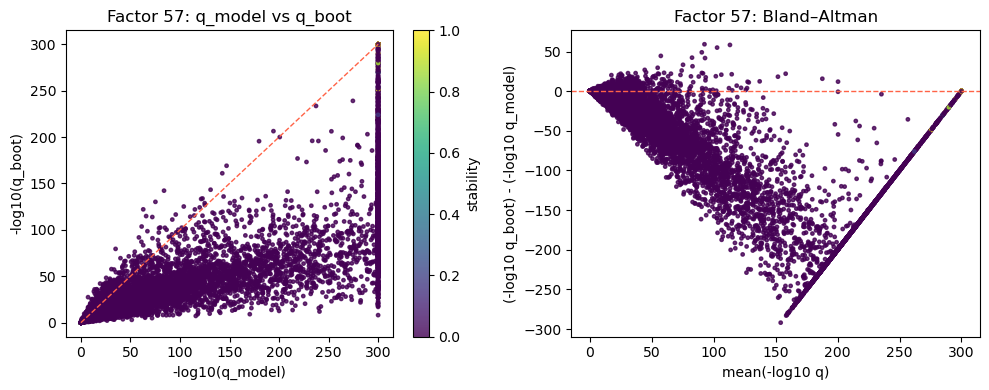

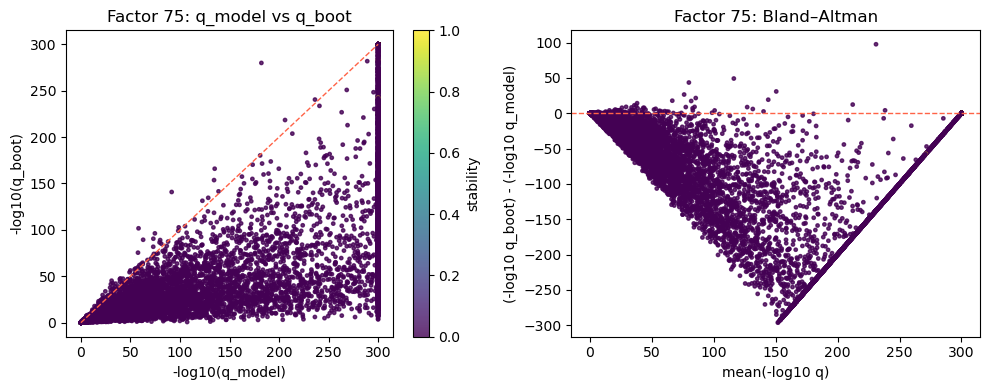

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a few representative factors (top 4 by #sig in bootstrap)
sig_counts_boot = (Q_boot < 0.05).sum(axis=0)
plot_factors2 = np.argsort(-sig_counts_boot)[:4]

for j in plot_factors2:
    x = -np.log10(np.clip(Q_model[:, j], 1e-300, 1.0))
    y = -np.log10(np.clip(Q_boot[:, j], 1e-300, 1.0))
    c = np.abs(L[:, j]) if np.all(np.isnan(stab[:, j])) else stab[:, j]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Scatter
    sc = axes[0].scatter(x, y, c=c, s=6, cmap="viridis", alpha=0.8)
    axes[0].plot([x.min(), x.max()], [x.min(), x.max()], ls="--", c="tomato", lw=1)
    axes[0].set_xlabel("-log10(q_model)")
    axes[0].set_ylabel("-log10(q_boot)")
    axes[0].set_title(f"Factor {j}: q_model vs q_boot")
    cb = plt.colorbar(sc, ax=axes[0])
    cb.set_label("|loading|" if np.all(np.isnan(stab[:, j])) else "stability")

    # Bland–Altman
    mean_val = 0.5 * (x + y)
    diff_val = y - x
    axes[1].scatter(mean_val, diff_val, c=c, s=6, cmap="viridis", alpha=0.8)
    axes[1].axhline(0.0, ls="--", c="tomato", lw=1)
    axes[1].set_xlabel("mean(-log10 q)")
    axes[1].set_ylabel("(-log10 q_boot) - (-log10 q_model)")
    axes[1].set_title(f"Factor {j}: Bland–Altman")
    plt.tight_layout()
    plt.show()


### BH calibration curves for p_model vs p_boot

What we’re doing:
- For representative factors, plot sorted p-values from model and bootstrap vs the BH 0.05 line.

What to look for:
- Where each curve crosses below the BH line indicates #discoveries at FDR=0.05; compare counts across methods.


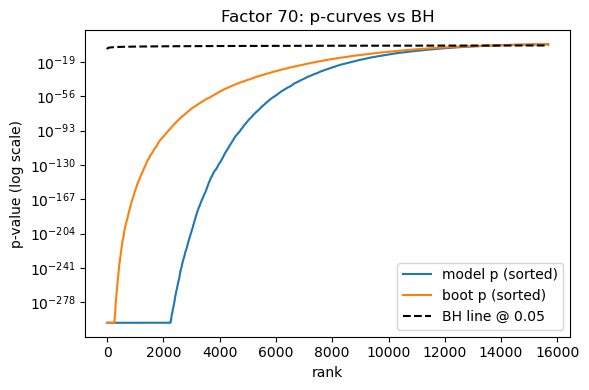

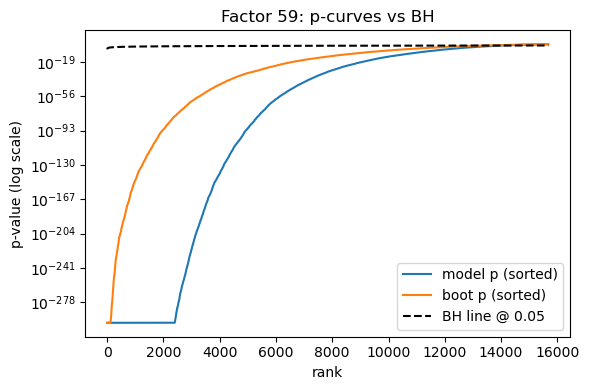

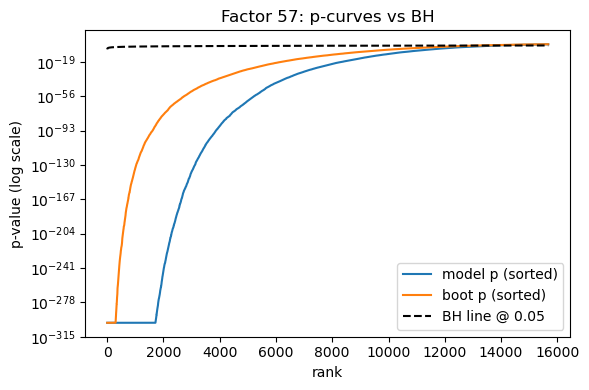

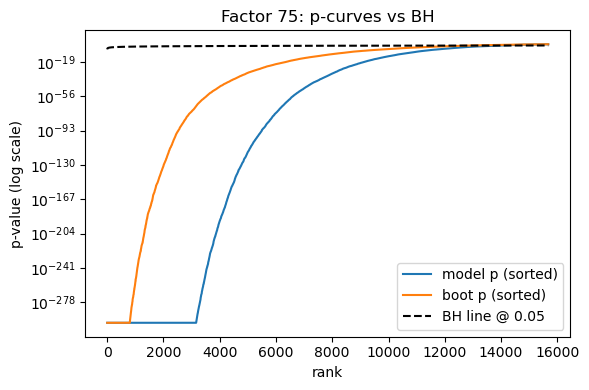

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Use model p if provided; otherwise approximate from q (already loaded as P_model)
# Bootstrap p is not written out in the earlier notebook; recompute from z if available else use q as surrogate
P_boot = np.asarray(ad_boot.varm.get("fs_loading_p", np.minimum(Q_boot, 1.0)))

plot_factors3 = plot_factors2  # reuse previous selection
alpha = 0.05
for j in plot_factors3:
    pm = np.clip(P_model[:, j], 1e-300, 1.0)
    pb = np.clip(P_boot[:, j], 1e-300, 1.0)
    pm_sorted = np.sort(pm)
    pb_sorted = np.sort(pb)
    m = len(pm_sorted)
    bh = (np.arange(1, m+1) / m) * alpha

    plt.figure(figsize=(6,4))
    plt.plot(pm_sorted, label="model p (sorted)")
    plt.plot(pb_sorted, label="boot p (sorted)")
    plt.plot(bh, ls="--", c="k", label=f"BH line @ {alpha}")
    plt.yscale("log")
    plt.xlabel("rank")
    plt.ylabel("p-value (log scale)")
    plt.title(f"Factor {j}: p-curves vs BH")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Concordance at fixed FDR thresholds

What we’re doing:
- For α in {0.01, 0.05, 0.10}, compute per-factor confusion matrix breakdown between model and bootstrap significant genes.

What to look for:
- High true-positive agreement (both sig) and low disagreements indicate consistent discoveries across methods.


In [10]:
import numpy as np
import pandas as pd

alphas = [0.01, 0.05, 0.10]

records = []
for j in range(k):
    for a in alphas:
        sig_m = (Q_model[:, j] < a)
        sig_b = (Q_boot[:, j] < a)
        tp = int(np.sum(sig_m & sig_b))
        fp = int(np.sum(sig_m & ~sig_b))  # model-only
        fn = int(np.sum(~sig_m & sig_b))  # boot-only
        tn = int(np.sum(~sig_m & ~sig_b))
        records.append({
            "factor": j, "alpha": a, "both_sig": tp, "model_only": fp, "boot_only": fn, "both_nonsig": tn,
            "jaccard_sig": tp / float(tp + fp + fn) if (tp + fp + fn) > 0 else np.nan,
        })

concord_df = pd.DataFrame(records)
concord_df.sort_values(["alpha", "jaccard_sig"], ascending=[True, False])


,factor,alpha,both_sig,model_only,boot_only,both_nonsig,jaccard_sig
210,70,0.01,12740,453,194,2292,0.951670
171,57,0.01,12487,751,22,2419,0.941704
42,14,0.01,10213,505,134,4827,0.941117
177,59,0.01,12713,834,3,2129,0.938229
18,6,0.01,10633,499,205,4342,0.937902
...,...,...,...,...,...,...,...
92,30,0.10,0,5697,0,9982,0.000000
128,42,0.10,0,6815,0,8864,0.000000
140,46,0.10,0,7298,0,8381,0.000000
248,82,0.10,0,7916,0,7763,0.000000


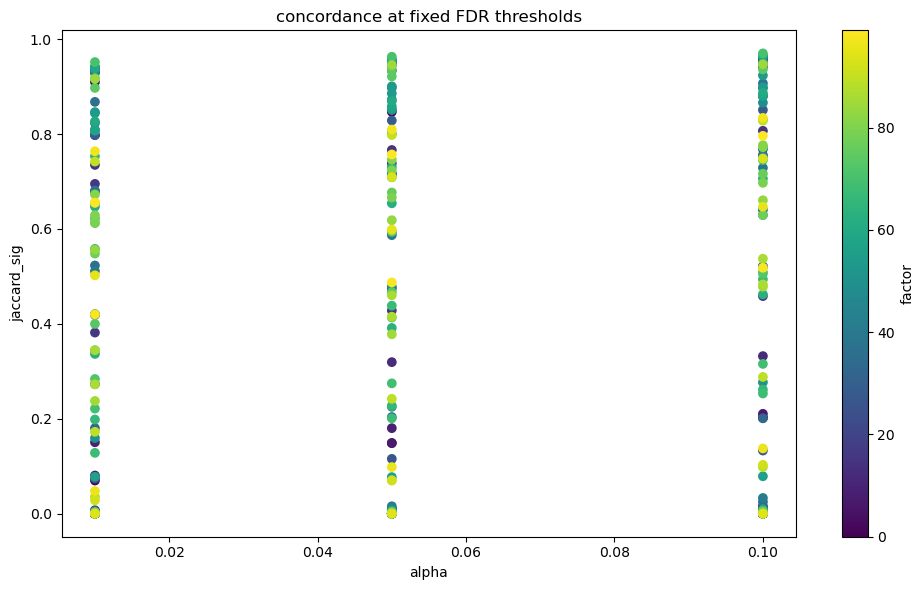

In [13]:
# plot the concord_df
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(concord_df["alpha"], concord_df["jaccard_sig"], c=concord_df["factor"], cmap="viridis")
plt.colorbar(label="factor")
plt.xlabel("alpha")
plt.ylabel("jaccard_sig")
plt.title("concordance at fixed FDR thresholds")
plt.tight_layout()
plt.show()


### SE comparison: model vs bootstrap

What we’re doing:
- For each factor, compare SE_model vs SE_boot across genes; compute correlations.

What to look for:
- Agreement suggests both methods reflect similar uncertainty; large systematic differences can indicate model misspecification or bootstrap sensitivity.


ValueError: zero-size array to reduction operation minimum which has no identity

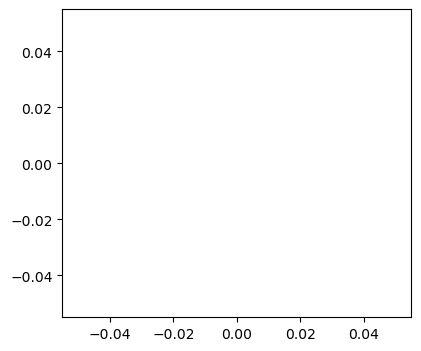

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Compute correlations per factor
se_corr_records = []
for j in range(k):
    se_b = SE_boot[:, j]
    se_m = SE_model[:, j]
    mask = np.isfinite(se_b) & np.isfinite(se_m)
    if mask.sum() < 3:
        r_p = np.nan
        r_s = np.nan
    else:
        r_p = pearsonr(se_b[mask], se_m[mask]).statistic if hasattr(pearsonr(se_b[mask], se_m[mask]), 'statistic') else pearsonr(se_b[mask], se_m[mask])[0]
        r_s = spearmanr(se_b[mask], se_m[mask]).correlation
    se_corr_records.append({"factor": j, "pearson": r_p, "spearman": r_s})

se_corr_df = pd.DataFrame(se_corr_records).sort_values("spearman", ascending=False)
se_corr_df.head(10)

# Plot a few example scatters
example_factors = se_corr_df.head(3)["factor"].tolist() + se_corr_df.tail(3)["factor"].tolist()
for j in example_factors:
    se_b = SE_boot[:, j]
    se_m = SE_model[:, j]
    mask = np.isfinite(se_b) & np.isfinite(se_m)
    plt.figure(figsize=(4.5,4))
    plt.scatter(se_m[mask], se_b[mask], s=6, alpha=0.6)
    mn = float(np.nanmin([se_m[mask].min(), se_b[mask].min()]))
    mx = float(np.nanmax([se_m[mask].max(), se_b[mask].max()]))
    plt.plot([mn, mx], [mn, mx], ls="--", c="tomato", lw=1)
    plt.xlabel("SE_model")
    plt.ylabel("SE_boot")
    plt.title(f"Factor {j}: SE comparison")
    plt.tight_layout()
    plt.show()


### Stability vs significance

What we’re doing:
- For each factor, relate stability to -log10(q_boot) and -log10(q_model).

What to look for:
- If stability captures robustness, we expect positive association with significance, especially for bootstrap; discrepancies with model may flag method differences.


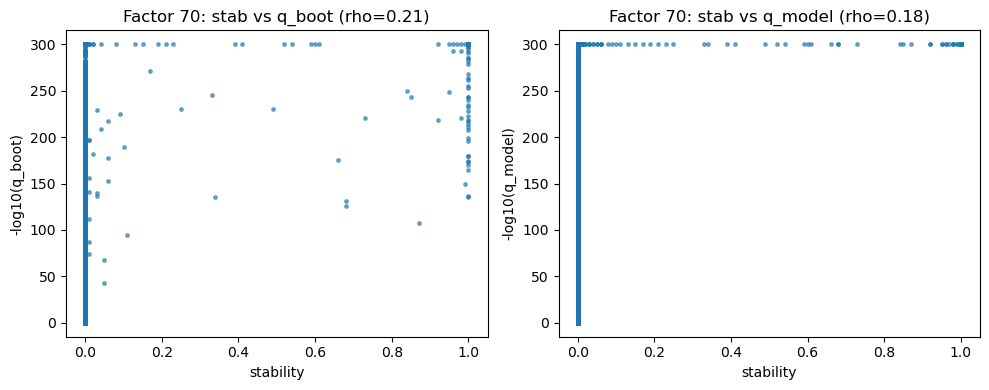

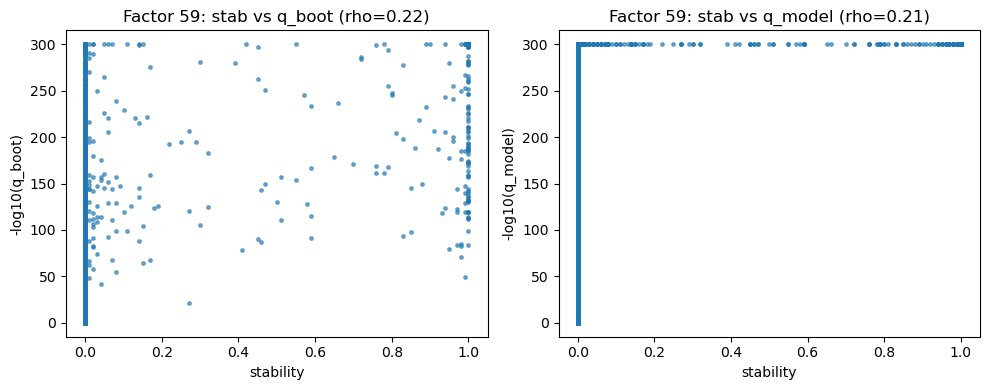

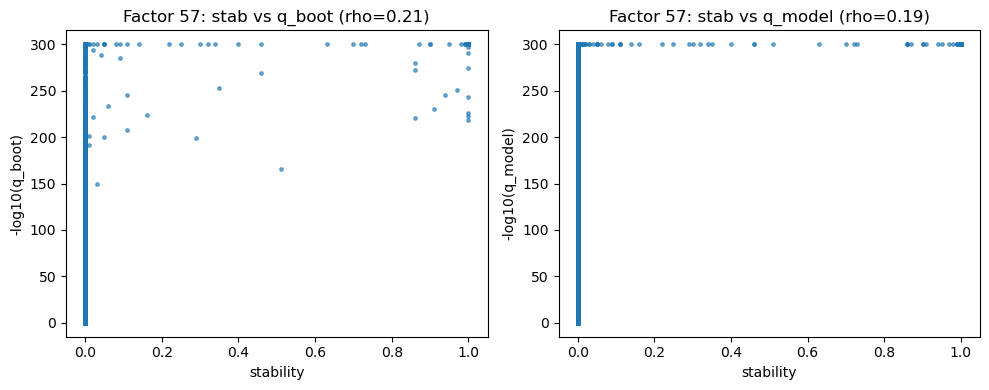

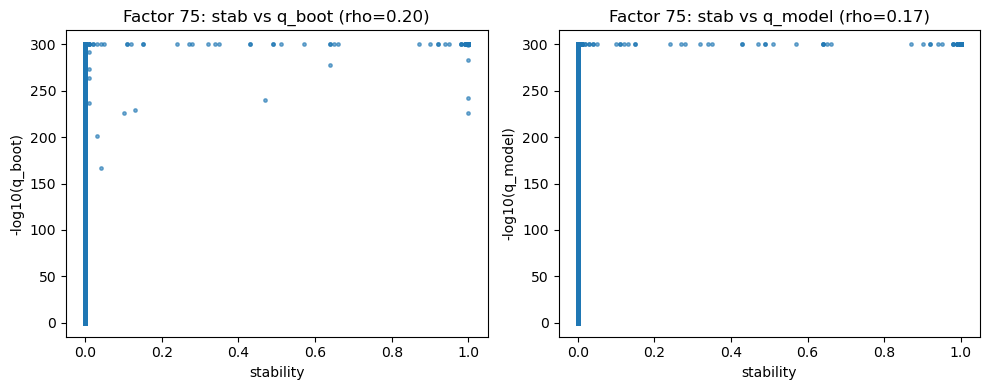

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

plot_factors4 = plot_factors2
for j in plot_factors4:
    st = stab[:, j]
    if np.all(np.isnan(st)):
        continue
    qm = -np.log10(np.clip(Q_model[:, j], 1e-300, 1.0))
    qb = -np.log10(np.clip(Q_boot[:, j], 1e-300, 1.0))
    m1 = np.isfinite(st) & np.isfinite(qb)
    m2 = np.isfinite(st) & np.isfinite(qm)
    corr_boot = spearmanr(st[m1], qb[m1]).correlation if m1.sum() > 3 else np.nan
    corr_model = spearmanr(st[m2], qm[m2]).correlation if m2.sum() > 3 else np.nan

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(st[m1], qb[m1], s=6, alpha=0.6)
    axes[0].set_xlabel("stability")
    axes[0].set_ylabel("-log10(q_boot)")
    axes[0].set_title(f"Factor {j}: stab vs q_boot (rho={corr_boot:.2f})")

    axes[1].scatter(st[m2], qm[m2], s=6, alpha=0.6)
    axes[1].set_xlabel("stability")
    axes[1].set_ylabel("-log10(q_model)")
    axes[1].set_title(f"Factor {j}: stab vs q_model (rho={corr_model:.2f})")

    plt.tight_layout()
    plt.show()


### Downstream enrichment agreement across rankers (R_load, R_boot, R_model)

What we’re doing:
- For selected factors, run GSEA (Hallmark) for each ranker and collect results.
- Compare per-factor: number of significant pathways (FDR<0.05), overlap of enriched sets (model vs bootstrap), and NES differences/correlations.

What to look for:
- Consistent pathway hits across rankers (especially model vs bootstrap) indicate agreement in downstream biology.
- Large NES shifts or low overlap may flag factors needing deeper inspection.


### Downstream enrichment agreement across rankers

Run GSEA (Hallmark) separately for `R_load`, `R_boot`, `R_model`; compare per-factor pathway counts, overlap between model and bootstrap, and NES differences/correlations.


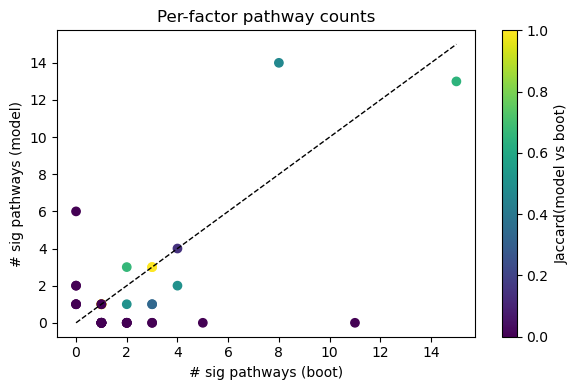

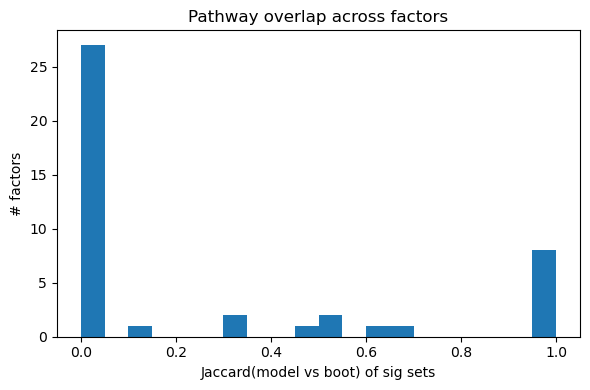

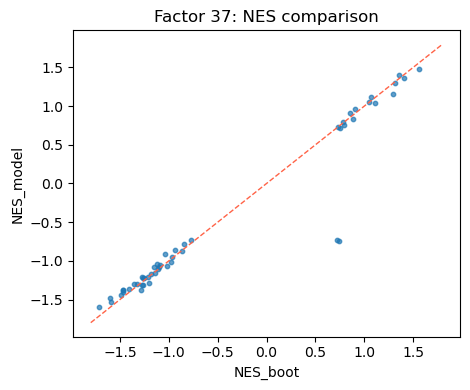

Factor 37 top pathways by NES_model - NES_boot:


,Term,NES_model,NES_boot,deltaNES
10,HALLMARK_COMPLEMENT,-0.906353,-1.038538,0.132185
6,HALLMARK_APOPTOSIS,-1.477128,-1.601888,0.12476
44,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-1.590415,-1.713164,0.122748
36,HALLMARK_P53_PATHWAY,-1.376069,-1.467366,0.091297
20,HALLMARK_HEME_METABOLISM,-1.379289,-1.467865,0.088576
9,HALLMARK_COAGULATION,-0.856173,-0.939005,0.082831
21,HALLMARK_HYPOXIA,-1.07508,-1.152698,0.077619
34,HALLMARK_NOTCH_SIGNALING,-1.04305,-1.117877,0.074827
47,HALLMARK_UV_RESPONSE_UP,-1.204731,-1.277195,0.072464
27,HALLMARK_KRAS_SIGNALING_DN,-1.398984,-1.46693,0.067947


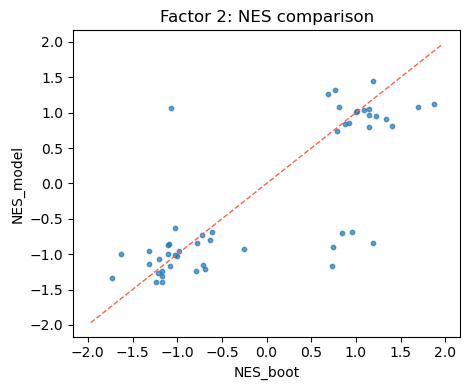

Factor 2 top pathways by NES_model - NES_boot:


,Term,NES_model,NES_boot,deltaNES
25,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.070335,-1.068274,2.138609
48,HALLMARK_WNT_BETA_CATENIN_SIGNALING,-0.995751,-1.633008,0.637256
33,HALLMARK_MYOGENESIS,1.265698,0.690565,0.575133
26,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.322974,0.759971,0.563004
19,HALLMARK_HEDGEHOG_SIGNALING,-1.332861,-1.727547,0.394685
17,HALLMARK_G2M_CHECKPOINT,-0.635045,-1.024765,0.38972
34,HALLMARK_NOTCH_SIGNALING,-0.957193,-1.320696,0.363502
44,HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.075283,0.805729,0.269554
47,HALLMARK_UV_RESPONSE_UP,1.443419,1.193229,0.25019
21,HALLMARK_HYPOXIA,-0.848664,-1.087832,0.239169


In [19]:
# Run GSEA for each ranker and compare downstream enrichment
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from IPython.display import display

# Rankers prepared earlier: R_load, R_boot, R_model (shape p×k) and gene names `boot_genes`
ranker_to_matrix = {
    "load": R_load,
    "boot": R_boot,
    "model": R_model,
}

def get_rank_series(matrix: np.ndarray, factor_index: int, gene_names: np.ndarray) -> pd.Series:
    s = pd.Series(matrix[:, factor_index], index=gene_names)
    return s.sort_values(ascending=False)


def run_or_read_prerank(series: pd.Series,
                         gene_sets: str,
                         out_dir: Path,
                         threads: int = 4,
                         permutations: int = 1000,
                         seed: int = 0,
                         min_size: int = 10,
                         max_size: int = 5000) -> pd.DataFrame:
    out_dir.mkdir(parents=True, exist_ok=True)
    # gseapy creates this file name by default for prerank
    report_csv = out_dir / "gseapy.gene_set.prerank.report.csv"
    if report_csv.exists():
        try:
            df = pd.read_csv(report_csv, sep="\t")
        except Exception:
            df = pd.read_csv(report_csv)
        return df

    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=gene_sets,
        threads=threads,  # newer gseapy prefers threads over processes
        permutation_num=permutations,
        outdir=str(out_dir),
        seed=seed,
        min_size=min_size,
        max_size=max_size,
        no_plot=True,
        format="png",
    )
    df = res.res2d.copy()
    # Harmonize column names if needed
    if "NES" not in df.columns and "nes" in df.columns:
        df = df.rename(columns={"nes": "NES"})
    if "FDR q-val" not in df.columns and "fdr" in df.columns:
        df = df.rename(columns={"fdr": "FDR q-val"})
    # Convenience export
    df.to_csv(out_dir / "report.parsed.csv", index=False)
    return df

# Configuration
hallmark_gmt = "/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt"
out_root = Path("/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_rankers_Oct14")
alpha = 0.05
selected_factors = list(range(k))  # adjust if you want to run a subset

summary_rows = []
nes_diffs = {}

for j in selected_factors:
    result_by_ranker = {}
    for name, mat in ranker_to_matrix.items():
        series = get_rank_series(mat, j, boot_genes)
        out_dir = out_root / name / f"factor_{j}"
        df = run_or_read_prerank(series, hallmark_gmt, out_dir)
        # Ensure a standard Term column exists
        if "Term" not in df.columns:
            if df.index.name is not None:
                df = df.reset_index().rename(columns={df.columns[0]: "Term"})
            else:
                df = df.rename(columns={df.columns[0]: "Term"})
        result_by_ranker[name] = df

    # Counts of significant pathways per ranker
    n_sig = {rk: int((df["FDR q-val"] < alpha).sum()) for rk, df in result_by_ranker.items()}

    # Overlap between model and bootstrap significant sets
    sig_model = set(result_by_ranker["model"].query("`FDR q-val` < @alpha")["Term"])
    sig_boot = set(result_by_ranker["boot"].query("`FDR q-val` < @alpha")["Term"])
    inter = sig_model & sig_boot
    union = sig_model | sig_boot
    jacc = (len(inter) / len(union)) if len(union) else np.nan

    # NES correlations and differences on the union of terms
    dfm = result_by_ranker["model"][["Term", "NES", "FDR q-val"]].rename(columns={"NES": "NES_model", "FDR q-val": "q_model"})
    dfb = result_by_ranker["boot"][ ["Term", "NES", "FDR q-val"]].rename(columns={"NES": "NES_boot",  "FDR q-val": "q_boot"})
    merged = pd.merge(dfm, dfb, on="Term", how="outer")
    if {"NES_model", "NES_boot"}.issubset(merged.columns):
        r = merged[["NES_model", "NES_boot"]].dropna()
        rho = r.corr(method="spearman").iloc[0, 1] if len(r) > 2 else np.nan
    else:
        rho = np.nan
    merged["deltaNES"] = merged.get("NES_model", np.nan) - merged.get("NES_boot", np.nan)
    nes_diffs[j] = merged.sort_values("deltaNES", ascending=False)

    summary_rows.append({
        "factor": j,
        "n_sig_load": n_sig.get("load", np.nan),
        "n_sig_boot": n_sig.get("boot", np.nan),
        "n_sig_model": n_sig.get("model", np.nan),
        "n_sig_intersection_model_boot": len(inter),
        "jaccard_model_boot": jacc,
        "spearman_NES_model_vs_boot": rho,
    })

summary_df = pd.DataFrame(summary_rows).sort_values("jaccard_model_boot", ascending=False)
summary_df.head()

# Quick visual summaries
plt.figure(figsize=(6, 4))
mx = float(np.nanmax(summary_df[["n_sig_boot", "n_sig_model"]].to_numpy())) if len(summary_df) else 1.0
plt.scatter(summary_df["n_sig_boot"], summary_df["n_sig_model"], c=summary_df["jaccard_model_boot"], cmap="viridis")
plt.plot([0, mx], [0, mx], ls="--", c="k", lw=1)
plt.colorbar(label="Jaccard(model vs boot)")
plt.xlabel("# sig pathways (boot)")
plt.ylabel("# sig pathways (model)")
plt.title("Per-factor pathway counts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(summary_df["jaccard_model_boot"].dropna(), bins=20)
plt.xlabel("Jaccard(model vs boot) of sig sets")
plt.ylabel("# factors")
plt.title("Pathway overlap across factors")
plt.tight_layout()
plt.show()

# Example per-factor NES comparison and top deltaNES table
example_factors = rank_stats_df.sort_values("spearman_bm", ascending=False).head(2)["factor"].tolist()
for j in example_factors:
    df = nes_diffs[j]
    if {"NES_boot", "NES_model"}.issubset(df.columns):
        plt.figure(figsize=(4.8, 4))
        plt.scatter(df["NES_boot"], df["NES_model"], s=10, alpha=0.7)
        lim = np.nanmax(np.abs(df[["NES_boot", "NES_model"]].to_numpy()))
        lim = 1.05 * lim if np.isfinite(lim) else 1.0
        plt.plot([-lim, lim], [-lim, lim], ls="--", c="tomato", lw=1)
        plt.xlabel("NES_boot")
        plt.ylabel("NES_model")
        plt.title(f"Factor {j}: NES comparison")
        plt.tight_layout()
        plt.show()
    print(f"Factor {j} top pathways by NES_model - NES_boot:")
    display(df[["Term", "NES_model", "NES_boot", "deltaNES"]].sort_values("deltaNES", ascending=False).head(10))


In [20]:
summary_df

,factor,n_sig_load,n_sig_boot,n_sig_model,n_sig_intersection_model_boot,jaccard_model_boot,spearman_NES_model_vs_boot
71,71,17,1,1,1,1.0,0.947563
58,58,10,1,1,1,1.0,0.960816
48,48,13,1,1,1,1.0,0.966579
20,20,8,3,3,3,1.0,0.946218
43,43,5,1,1,1,1.0,0.929028
...,...,...,...,...,...,...,...
92,92,0,0,0,0,NaN,0.697959
93,93,1,0,0,0,NaN,0.974838
94,94,16,0,0,0,NaN,0.869100
97,97,4,0,0,0,NaN,0.950252


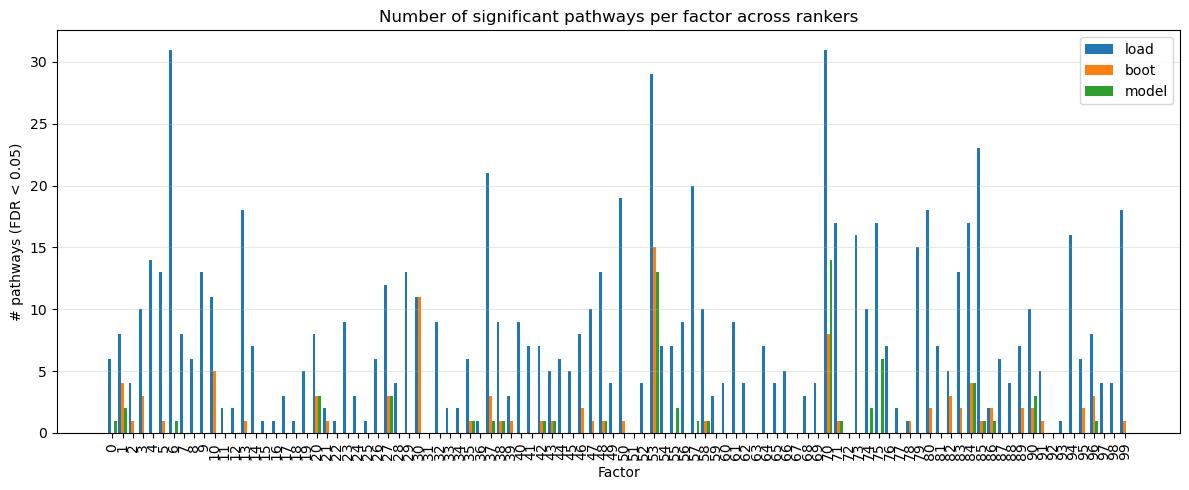

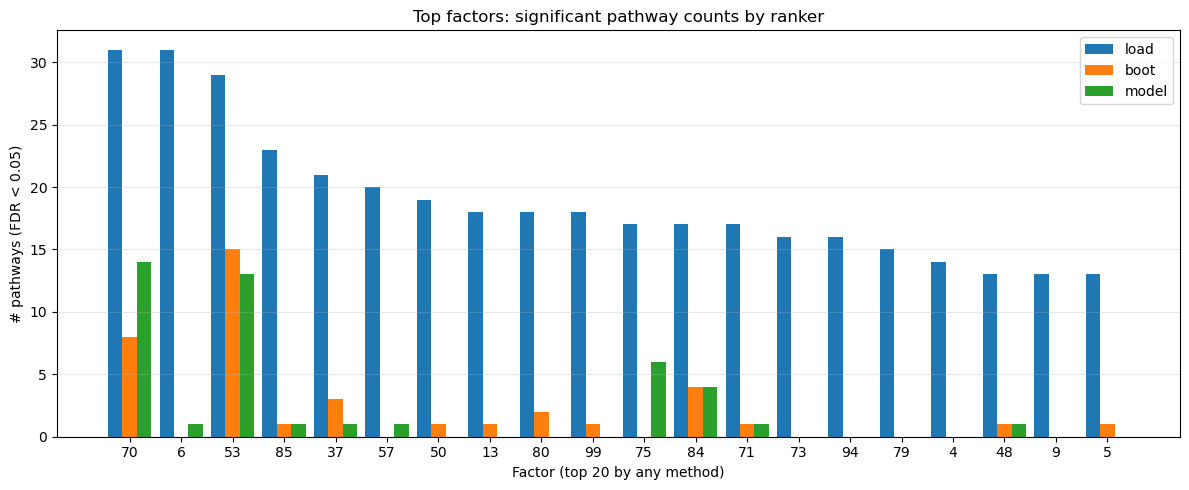

In [21]:
# Save GSEA outputs in legacy directories and plot per-factor counts for all rankers
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse: run_or_read_prerank(), get_rank_series(), ranker_to_matrix, boot_genes, k
alpha = 0.05

ranker_to_outroot = {
    # pure loadings (already produced before under just_loading)
    "load": Path("/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_bootstrap_oct7/just_loading"),
    # bootstrap-weighted: -log10(q_boot) * L
    "boot": Path("/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_bootstrap_oct7/combine_boot_sig_n_loading"),
    # model-weighted: -log10(q_model) * L
    "model": Path("/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_model_oct7/combine_model_sig_n_loading"),
}

summary_counts = []  # rows: {factor, load, boot, model}
for j in range(k):
    counts = {"factor": j}
    for rk, mat in ranker_to_matrix.items():
        series = get_rank_series(mat, j, boot_genes)
        out_dir = ranker_to_outroot[rk] / f"factor_{j}"
        df = run_or_read_prerank(series, hallmark_gmt, out_dir)
        # tolerant column names
        qcol = "FDR q-val" if "FDR q-val" in df.columns else ("fdr" if "fdr" in df.columns else None)
        if qcol is None:
            raise RuntimeError("Cannot find FDR q-val column in GSEA report for ranker '{rk}', factor {j}")
        counts[rk] = int((df[qcol] < alpha).sum())
    summary_counts.append(counts)

summary_counts_df = pd.DataFrame(summary_counts)
summary_counts_df.head()

# Grouped bar plot across factors (may be wide, but gives a full picture)
fig, ax = plt.subplots(figsize=(max(10, k*0.12), 5))
idx = np.arange(k)
bar_w = 0.28
ax.bar(idx - bar_w, summary_counts_df["load"], width=bar_w, label="load")
ax.bar(idx,          summary_counts_df["boot"], width=bar_w, label="boot")
ax.bar(idx + bar_w,  summary_counts_df["model"], width=bar_w, label="model")
ax.set_xlabel("Factor")
ax.set_ylabel(f"# pathways (FDR < {alpha})")
ax.set_title("Number of significant pathways per factor across rankers")
ax.set_xticks(idx)
ax.set_xticklabels(summary_counts_df["factor"].astype(int), rotation=90)
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Focused view: top 20 factors by max count across rankers
top_idx = (
    summary_counts_df.assign(max_count=summary_counts_df[["load","boot","model"]].max(axis=1))
    .sort_values("max_count", ascending=False)
    .head(20)
    .index
)
sub = summary_counts_df.loc[top_idx]
fig, ax = plt.subplots(figsize=(12, 5))
idx2 = np.arange(len(sub))
ax.bar(idx2 - bar_w, sub["load"], width=bar_w, label="load")
ax.bar(idx2,          sub["boot"], width=bar_w, label="boot")
ax.bar(idx2 + bar_w,  sub["model"], width=bar_w, label="model")
ax.set_xlabel("Factor (top 20 by any method)")
ax.set_ylabel(f"# pathways (FDR < {alpha})")
ax.set_title("Top factors: significant pathway counts by ranker")
ax.set_xticks(idx2)
ax.set_xticklabels(sub["factor"].astype(int), rotation=0)
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
